CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nnF
import torch.optim as optim
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets, transforms
import numpy as np

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=4),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    ])

# Test data transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    ])

In [4]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(test_transforms))

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 4

In [5]:
from utils import get_mnist_data

train_data, test_data = get_mnist_data(train_transforms, test_transforms)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, **kwargs)
test_loader = torch.utils.data.DataLoader(test, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

In [7]:
# import matplotlib.pyplot as plt

# batch_data, batch_label = next(iter(train_loader))

# fig = plt.figure()


CODE BLOCK: 7

In [8]:
from model import ResNet18

CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:
from utils import train, test
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

CODE BLOCK: 10

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.10E-02


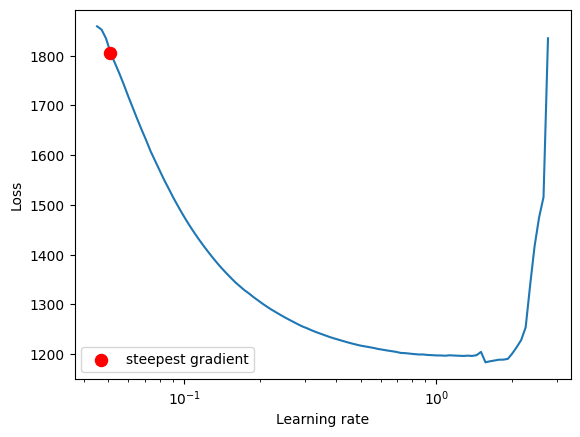

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = ResNet18().to(device)
from torch.optim.lr_scheduler import OneCycleLR
criterion = nnF.CrossEntropyLoss(reduction="sum")
!pip install torch-lr-finder


from torch_lr_finder import LRFinder

model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nnF.CrossEntropyLoss(reduction="sum")
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=8E-04)
num_epochs = 20
scheduler = OneCycleLR(
    optimizer,
    max_lr = 5.10E-02,
    steps_per_epoch = len(train_loader),
    epochs = num_epochs,
    pct_start = 5/num_epochs,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100
)


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  model, train_losses, train_acc = train(model, device, train_loader, optimizer, train_losses, train_acc, scheduler, criterion)
  model, test_losses, test_acc = test(model, device, test_loader, test_losses, test_acc, criterion)
  # scheduler.step()

Epoch 1


Loss=463.0844421386719 Batch_id=97 Accuracy=42.72: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 3.2739, Accuracy: 2988/10000 (29.88%)

Epoch 2


Loss=456.6808776855469 Batch_id=97 Accuracy=55.12: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 2.7338, Accuracy: 3227/10000 (32.27%)

Epoch 3


Loss=296.79901123046875 Batch_id=97 Accuracy=64.02: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 1.1216, Accuracy: 6540/10000 (65.40%)

Epoch 4


Loss=236.62657165527344 Batch_id=97 Accuracy=71.16: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 0.9617, Accuracy: 7060/10000 (70.60%)

Epoch 5


Loss=234.1915283203125 Batch_id=97 Accuracy=75.64: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.7177, Accuracy: 7536/10000 (75.36%)

Epoch 6


Loss=209.46849060058594 Batch_id=97 Accuracy=79.33: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.5801, Accuracy: 8010/10000 (80.10%)

Epoch 7


Loss=195.4078369140625 Batch_id=97 Accuracy=81.99: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.6973, Accuracy: 7775/10000 (77.75%)

Epoch 8


Loss=152.39682006835938 Batch_id=97 Accuracy=84.14: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 0.5485, Accuracy: 8235/10000 (82.35%)

Epoch 9


Loss=135.28958129882812 Batch_id=97 Accuracy=86.00: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.4893, Accuracy: 8369/10000 (83.69%)

Epoch 10


Loss=111.47572326660156 Batch_id=97 Accuracy=87.75: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.4629, Accuracy: 8531/10000 (85.31%)

Epoch 11


Loss=112.74595642089844 Batch_id=97 Accuracy=89.46: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.4811, Accuracy: 8467/10000 (84.67%)

Epoch 12


Loss=89.92513275146484 Batch_id=97 Accuracy=90.72: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.4427, Accuracy: 8604/10000 (86.04%)

Epoch 13


Loss=59.880401611328125 Batch_id=97 Accuracy=92.06: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.3907, Accuracy: 8810/10000 (88.10%)

Epoch 14


Loss=69.32398223876953 Batch_id=97 Accuracy=93.74: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3317, Accuracy: 8963/10000 (89.63%)

Epoch 15


Loss=55.62813186645508 Batch_id=97 Accuracy=94.95: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.3503, Accuracy: 8975/10000 (89.75%)

Epoch 16


Loss=40.79164505004883 Batch_id=97 Accuracy=96.00: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.3266, Accuracy: 9035/10000 (90.35%)

Epoch 17


Loss=30.80684471130371 Batch_id=97 Accuracy=97.02: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3265, Accuracy: 9121/10000 (91.21%)

Epoch 18


Loss=13.116378784179688 Batch_id=97 Accuracy=97.52: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.3137, Accuracy: 9134/10000 (91.34%)

Epoch 19


Loss=16.901878356933594 Batch_id=97 Accuracy=97.93: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.3192, Accuracy: 9143/10000 (91.43%)

Epoch 20


Loss=17.827363967895508 Batch_id=97 Accuracy=98.16: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 0.3179, Accuracy: 9142/10000 (91.42%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

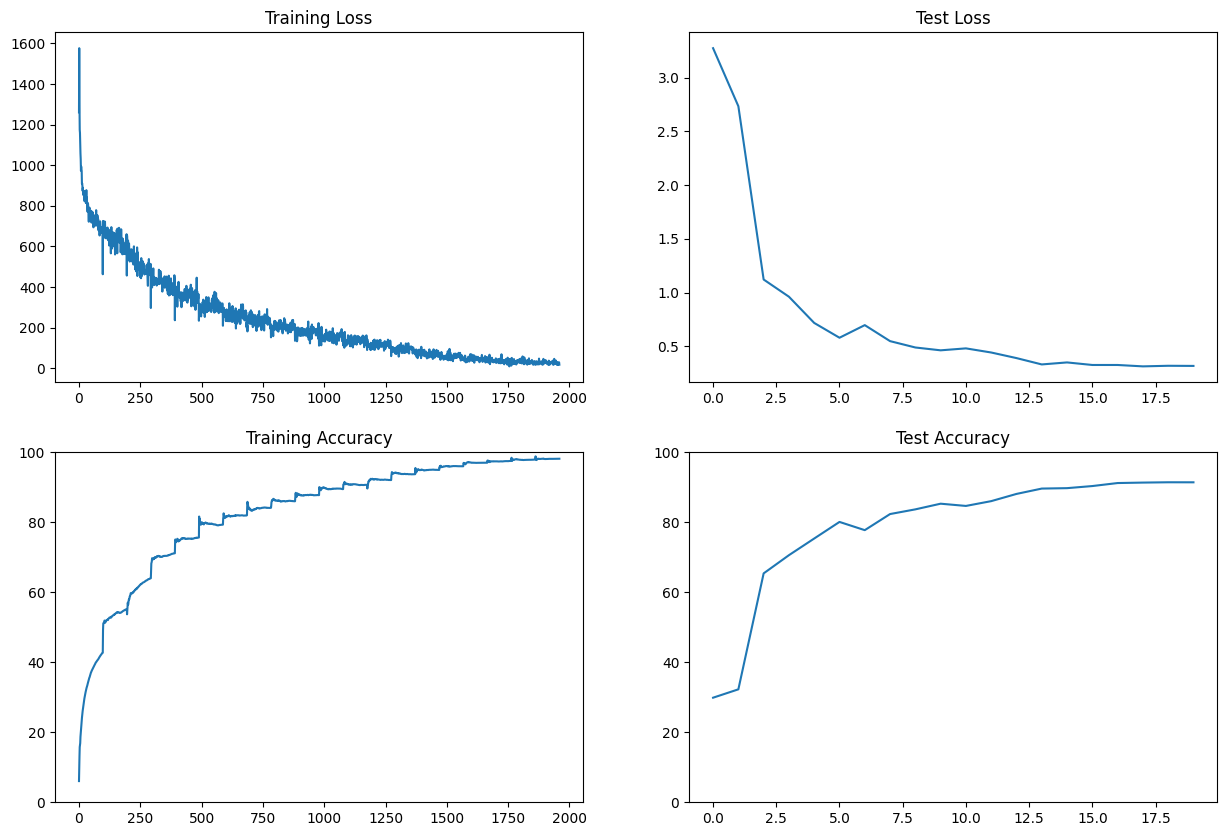

In [13]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


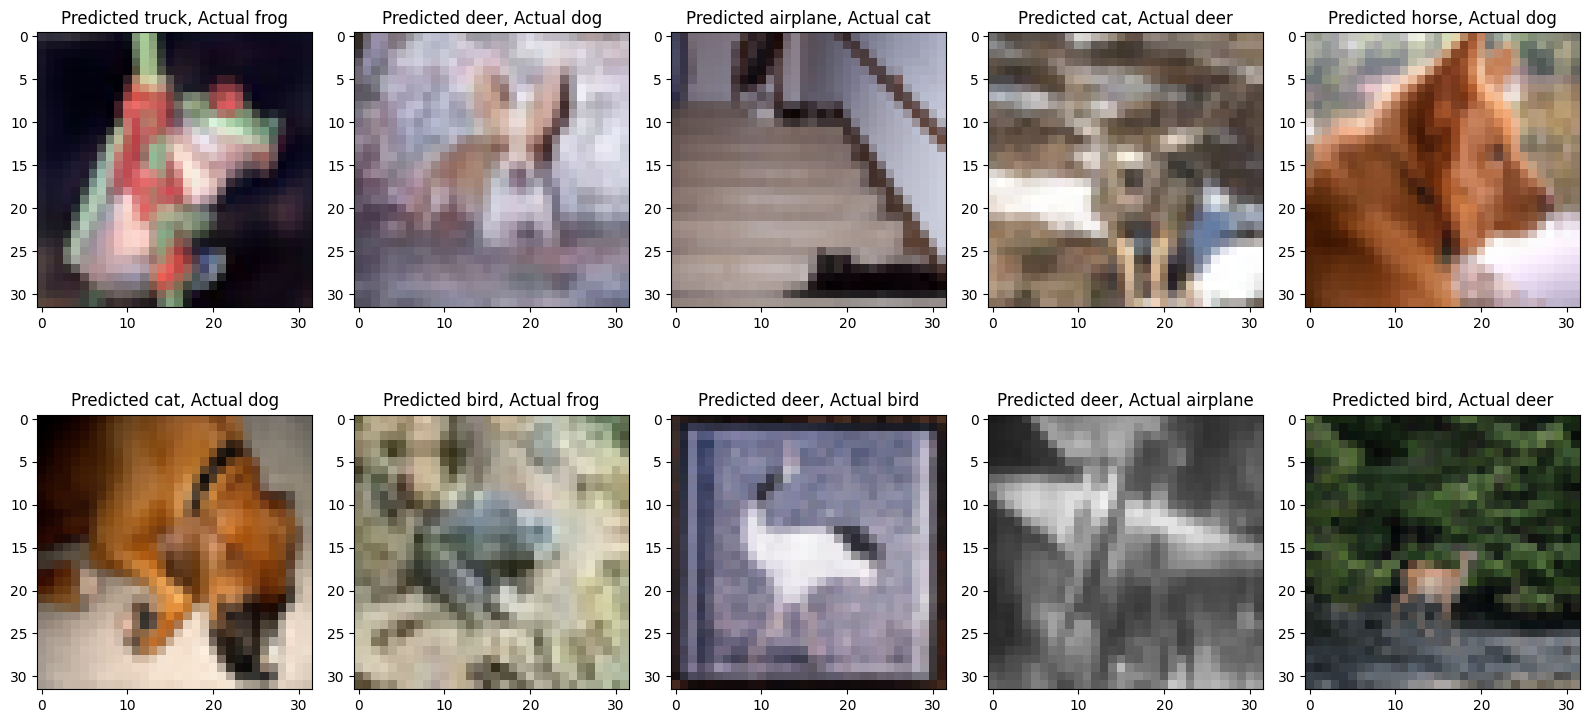

In [14]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()

In [18]:
!pip install grad-cam

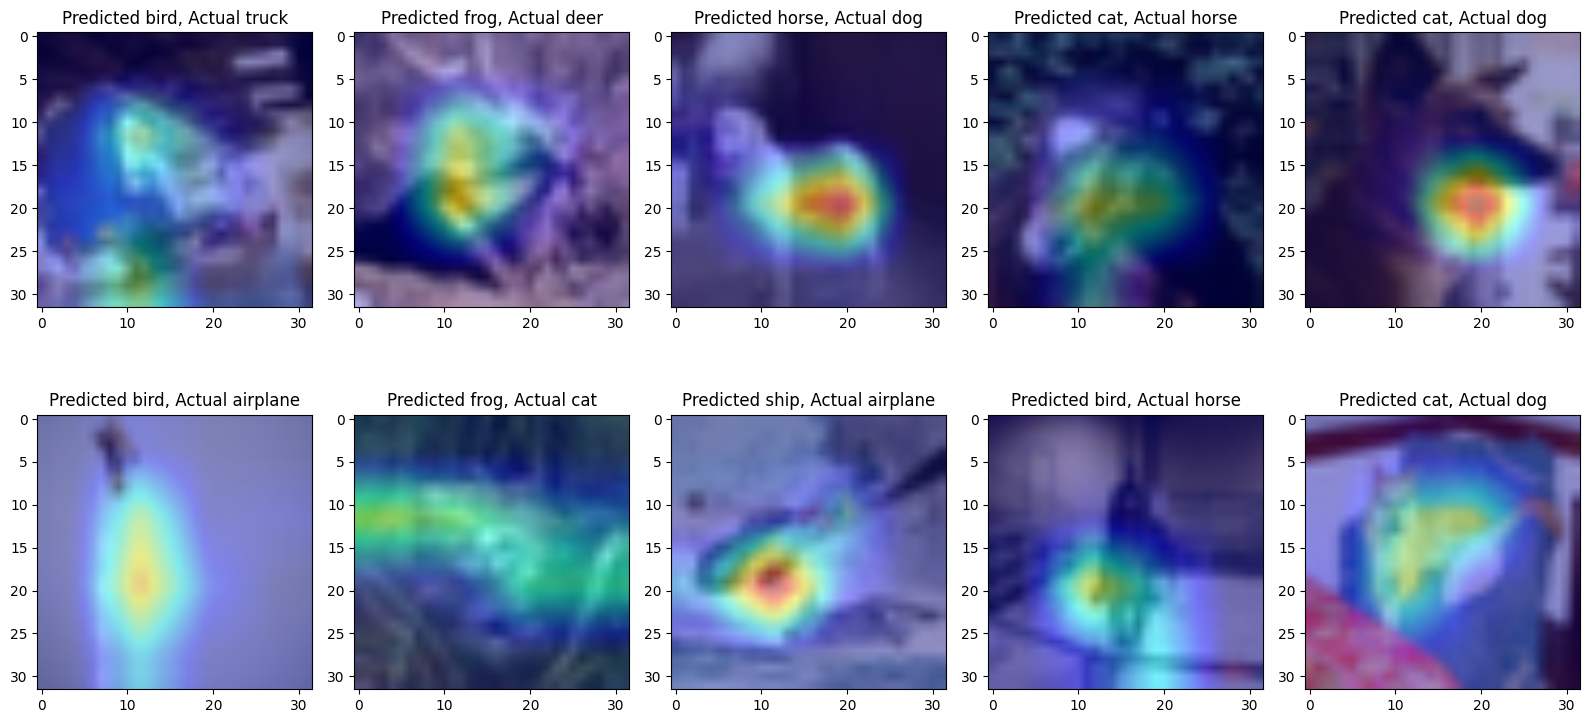

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    grayscale_cam = cam(input_tensor=image_tensor.reshape(1,3,32,32), targets=[ClassifierOutputTarget(predicted_labels[i])],aug_smooth=True,eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(imshow(image), grayscale_cam, use_rgb=True,image_weight=0.6)
    #ax.imshow(np.transpose(imshow(visualization), (2, 0, 1)))  # Display the image
    ax.imshow(visualization,interpolation='bilinear')
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()